# Setup do ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.ensemble import IsolationForest
import warnings

warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 7)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


# Carregamento dos Dados

## Carregar o dataset


Carregar o dataset diretamente do [Github](https://github.com/diegonogare/Workshop-AnalisePreditivaDeManutencao/blob/main/conjuntoDados.csv).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/diegonogare/Workshop-AnalisePreditivaDeManutencao/refs/heads/main/conjuntoDados.csv',
                 names=['ID', 'Timestamp', 'Temperatura', 'Sinais', 'Desligou'])

In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Dia'] = df['Timestamp'].dt.day
df['DiaSemana'] = df['Timestamp'].dt.day_name()
df['Hora'] = df['Timestamp'].dt.time

df = df[df['Dia'] != (7)]
df = df[df['Dia'] != (29)]


## Conhecer o básico do dataset

Após o dataset ser carregado, é importante analisar seu conteúdo para conhecer o que há lá dentro.

In [4]:
print("\nDataset carregado com sucesso!")
print("Formato do dataset (linhas x colunas):", df.shape)

print("\nPrimeiras 5 linhas do dataset:")
print(df.head())

print("\nInformações do dataset:")
df.info()

print("\nEstatística descritivas:")
print(df.describe())

print("\nValores nulos por Coluna:")
print(df.isnull().sum())


Dataset carregado com sucesso!
Formato do dataset (linhas x colunas): (120960, 8)

Primeiras 5 linhas do dataset:
   ID           Timestamp  Temperatura  Sinais  Desligou  Dia DiaSemana  \
0   1 2018-04-30 02:36:00        19.59       5         0   30    Monday   
1   2 2018-04-30 02:36:05        19.18       4         0   30    Monday   
2   3 2018-04-30 02:36:10        19.38       3         0   30    Monday   
3   4 2018-04-30 02:36:15        19.26       4         0   30    Monday   
4   5 2018-04-30 02:36:20        19.52       5         0   30    Monday   

       Hora  
0  02:36:00  
1  02:36:05  
2  02:36:10  
3  02:36:15  
4  02:36:20  

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 120960 entries, 0 to 131583
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ID           120960 non-null  int64         
 1   Timestamp    120960 non-null  datetime64[ns]
 2   Temperatura  12

# Análise Exploratória Descritiva (EDA)

In [5]:
colunas_numericas = df.select_dtypes(include=np.number).columns.tolist()
colunas_numericas

colunas_numericas.remove('ID') #ID da transação
colunas_numericas.remove('Desligou') #Flag se desligou ou não
colunas_numericas


['Temperatura', 'Sinais', 'Dia']

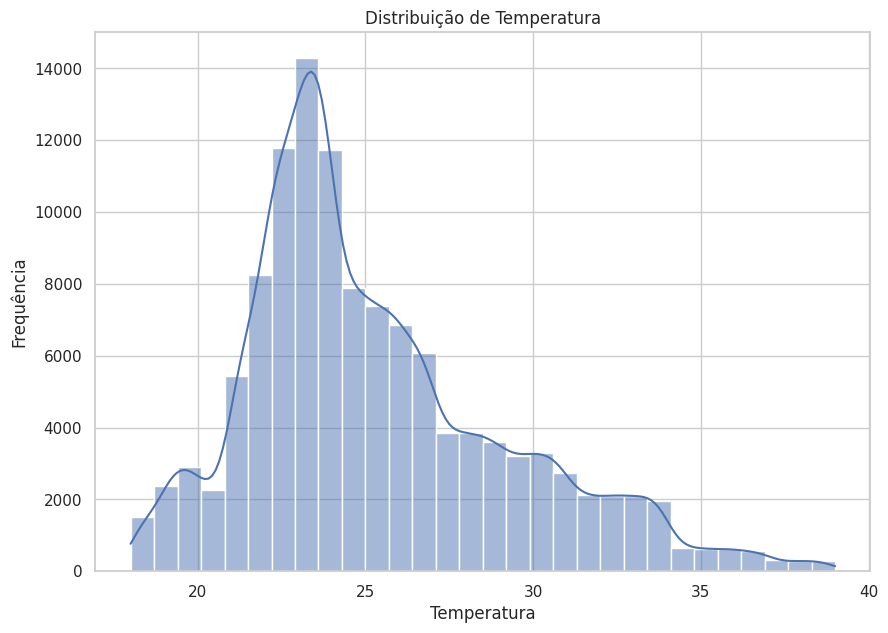

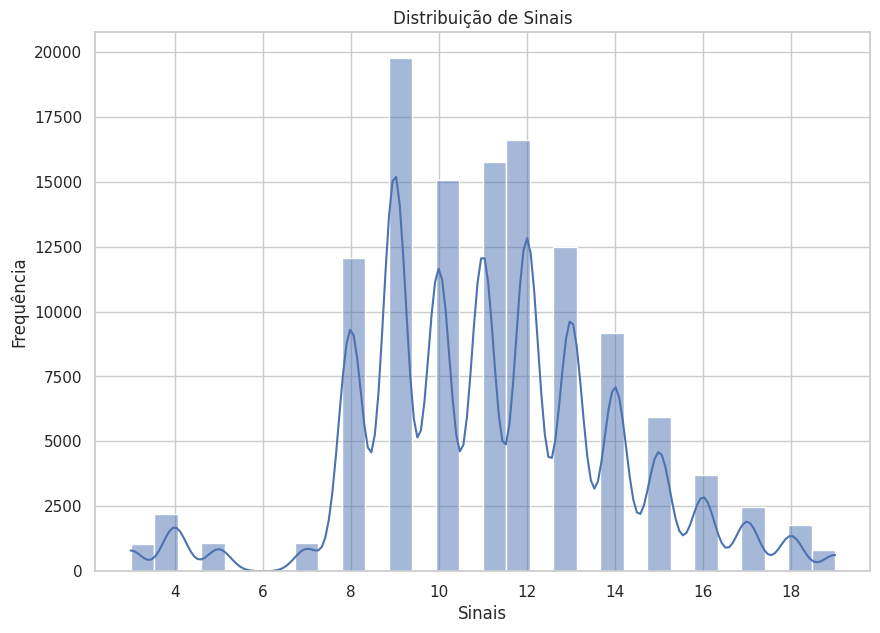

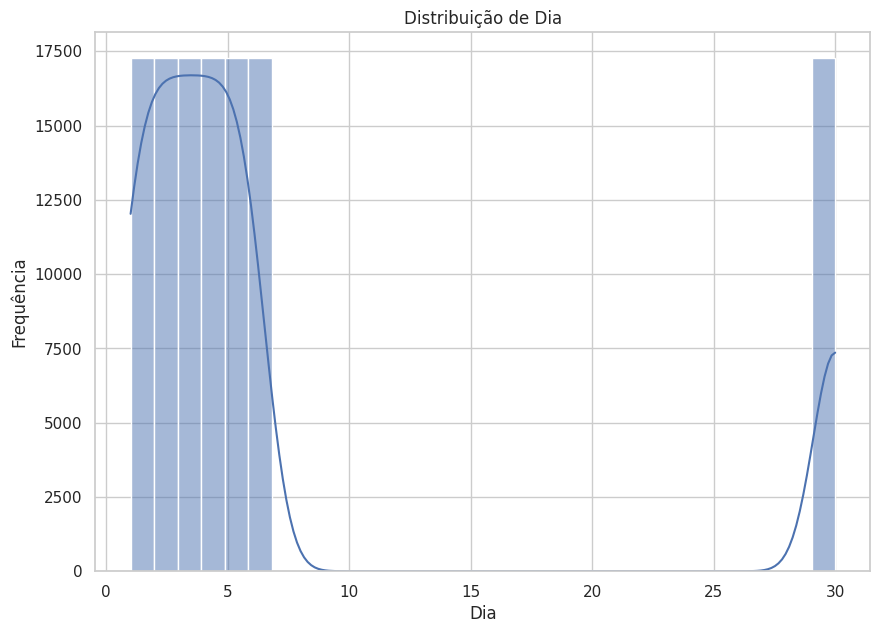

In [6]:
for col in colunas_numericas:
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()
    print("\n")

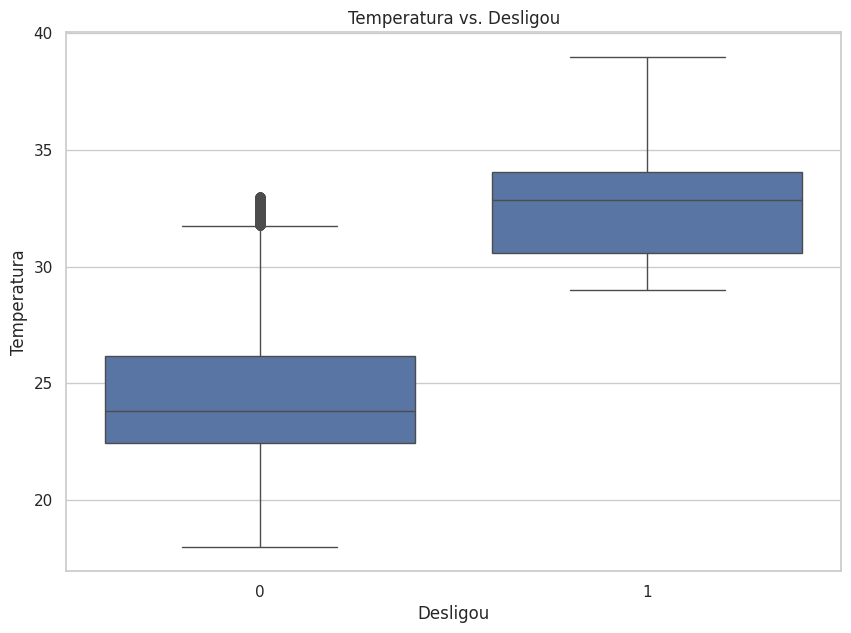

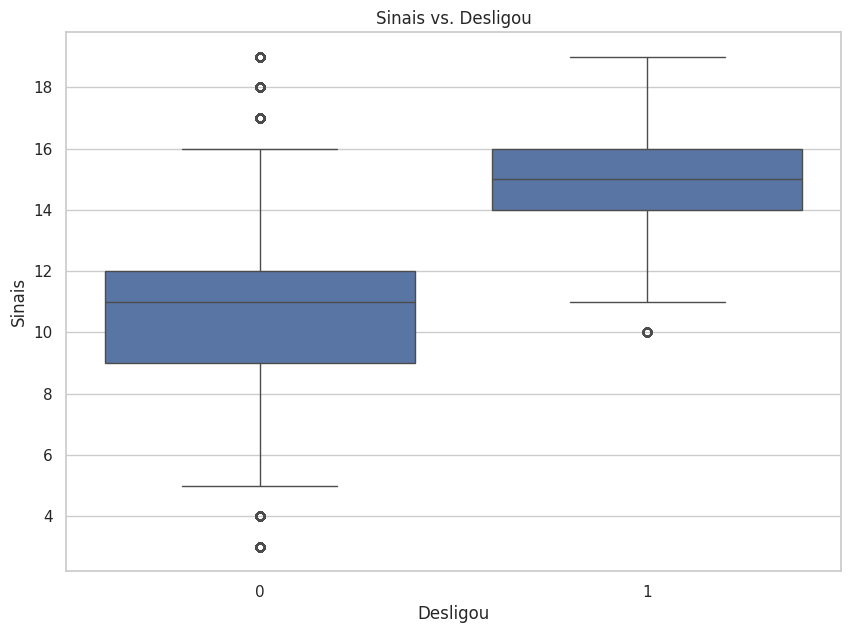

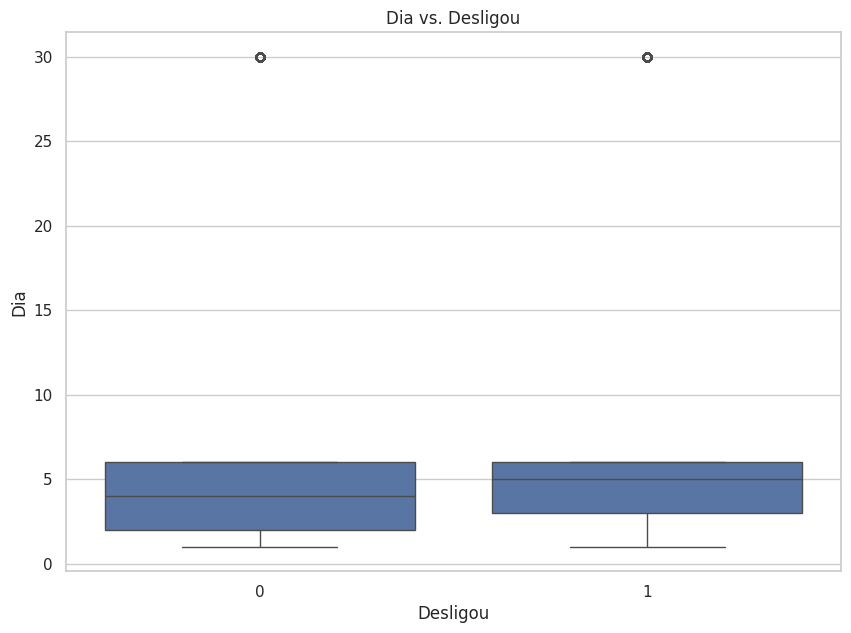

In [7]:
for col in colunas_numericas:
    sns.boxplot(x='Desligou', y=col, data=df)
    plt.title(f'{col} vs. Desligou')
    plt.show()
    print("\n")

In [8]:
#Pela exploração que fizemos, apesar de Dia ser um valor numério, não tem relação com o objetivo que temos. Vamos remover
colunas_numericas.remove('Dia')

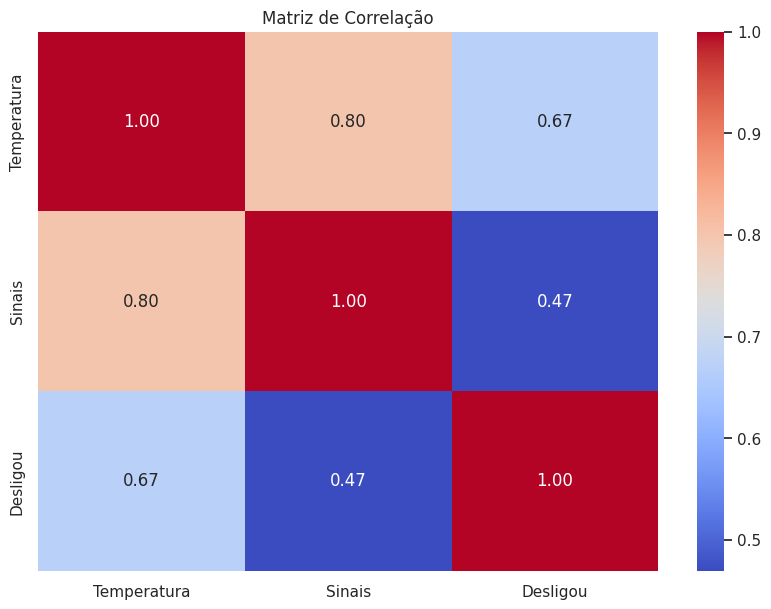

In [9]:
correlation_matrix = df[colunas_numericas + ['Desligou']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

### 1 - Quais horários a temperatura da fábrica é mais alta?

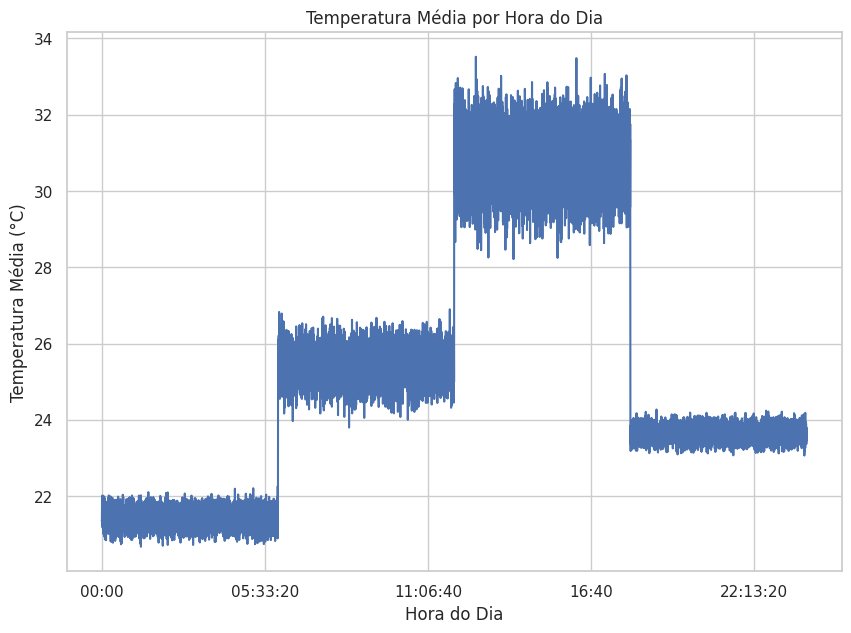

In [10]:
temperatura = df.copy()
temperatura.drop(columns=['Timestamp', 'Dia', 'Sinais', 'Desligou'], inplace=True )

temperatura.groupby('Hora')['Temperatura'].mean('Temperatura').plot(kind='line', marker='')
plt.title('Temperatura Média por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Temperatura Média (°C)')
plt.grid(True)
plt.show()


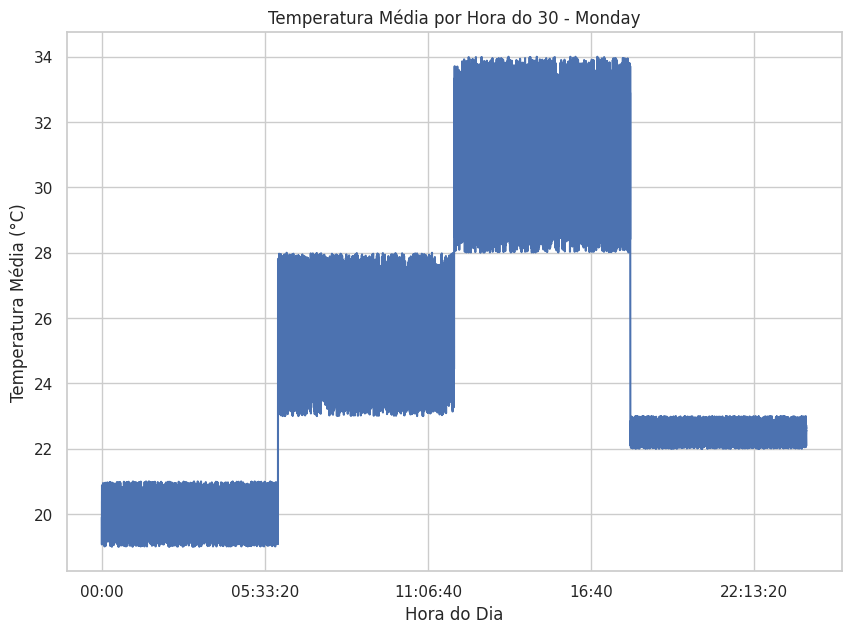

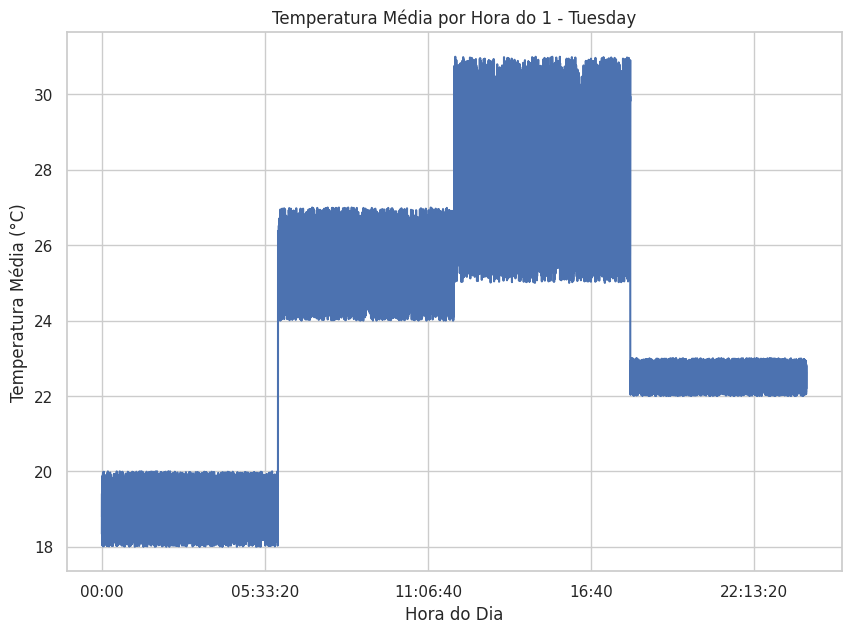

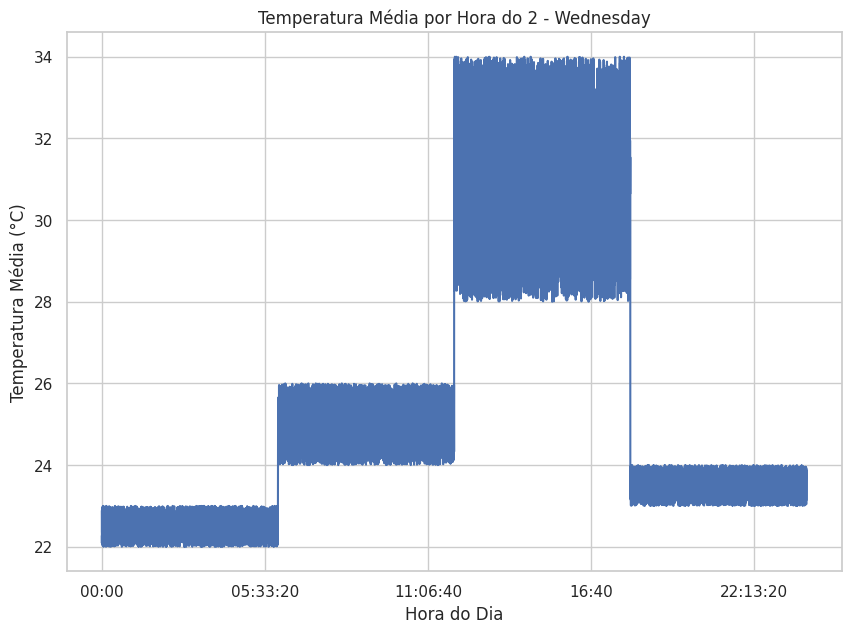

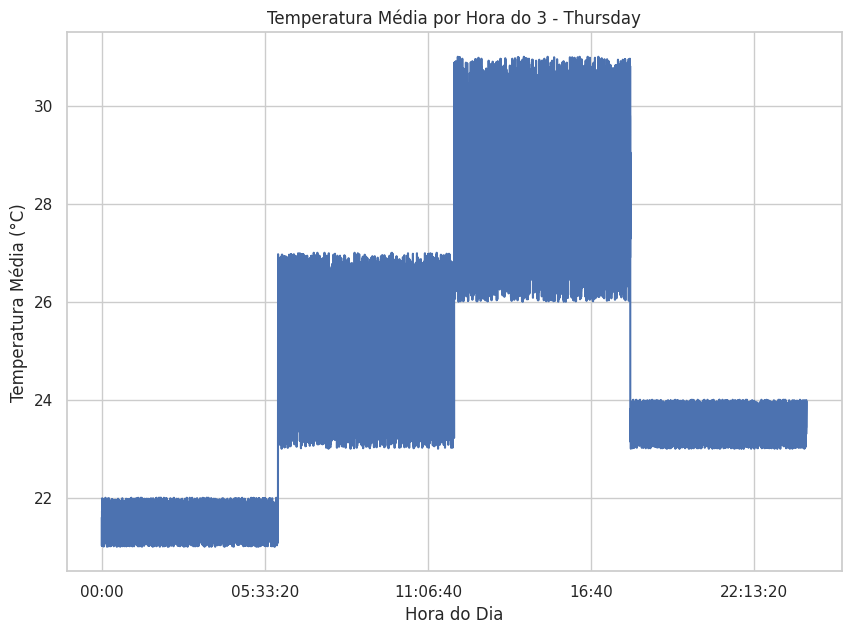

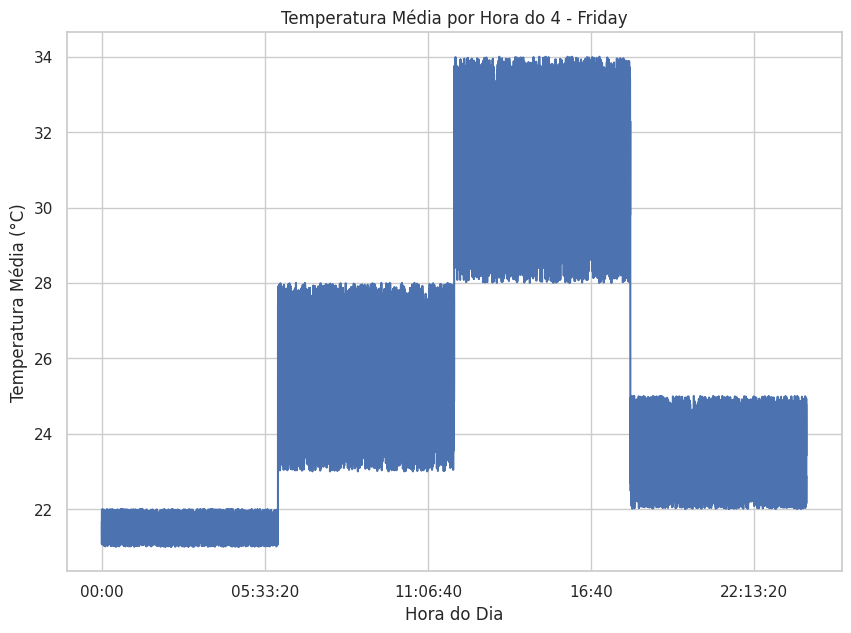

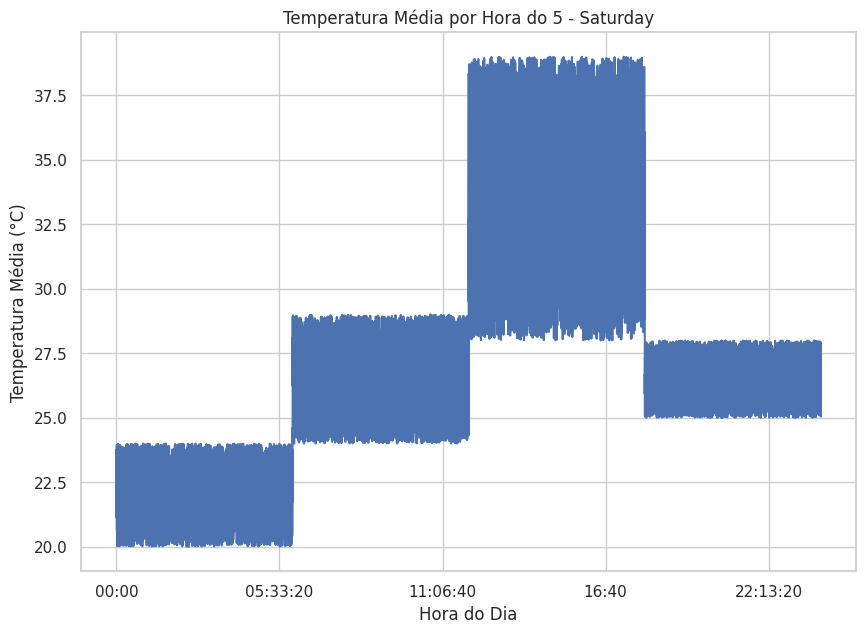

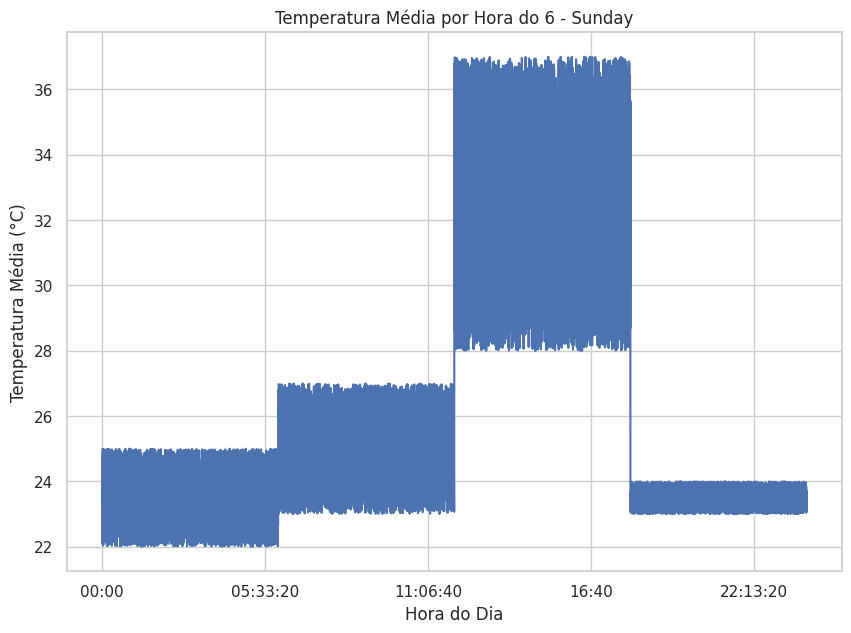

In [11]:
for dia in df['Dia'].unique():
    temperaturaDiaria = df.copy()
    temperaturaDiaria = temperaturaDiaria[temperaturaDiaria['Dia'] == dia]
    temperaturaDiaria.drop(columns=['Timestamp', 'Sinais', 'Desligou'], inplace=True )
    diaSemana = temperaturaDiaria['DiaSemana'].iloc[0]

    temperaturaDiaria.groupby('Hora')['Temperatura'].mean('Temperatura').plot(kind='line', marker='')
    plt.title(f'Temperatura Média por Hora do {dia} - {diaSemana}')
    plt.xlabel('Hora do Dia')
    plt.ylabel('Temperatura Média (°C)')
    plt.grid(True)
    plt.show()

    print("\n")


### 2 - Quais temperaturas normalmente levam a máquina a parar de funcionar?


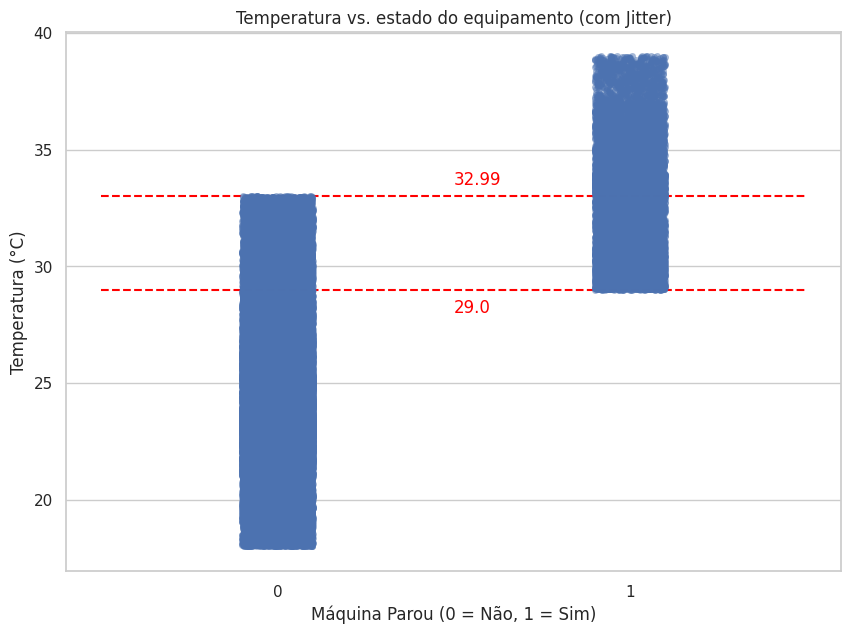

In [12]:
maxFuncionando = df[df['Desligou'] == 0]['Temperatura'].max()
minNaoFuncionando = df[df['Desligou'] == 1]['Temperatura'].min()

sns.stripplot(x='Desligou', y='Temperatura', data=df, jitter=True, alpha=0.5)
plt.title('Temperatura vs. estado do equipamento (com Jitter)')
plt.xlabel('Máquina Parou (0 = Não, 1 = Sim)')
plt.ylabel('Temperatura (°C)')
plt.hlines(y=[maxFuncionando, minNaoFuncionando], xmin=-0.5, xmax=1.5, colors='red', linestyles='dashed')
plt.text(x=0.5, y=minNaoFuncionando - 1, s=minNaoFuncionando, color='red' )
plt.text(x=0.5, y=maxFuncionando + 0.5, s=maxFuncionando, color='red' )
plt.show()

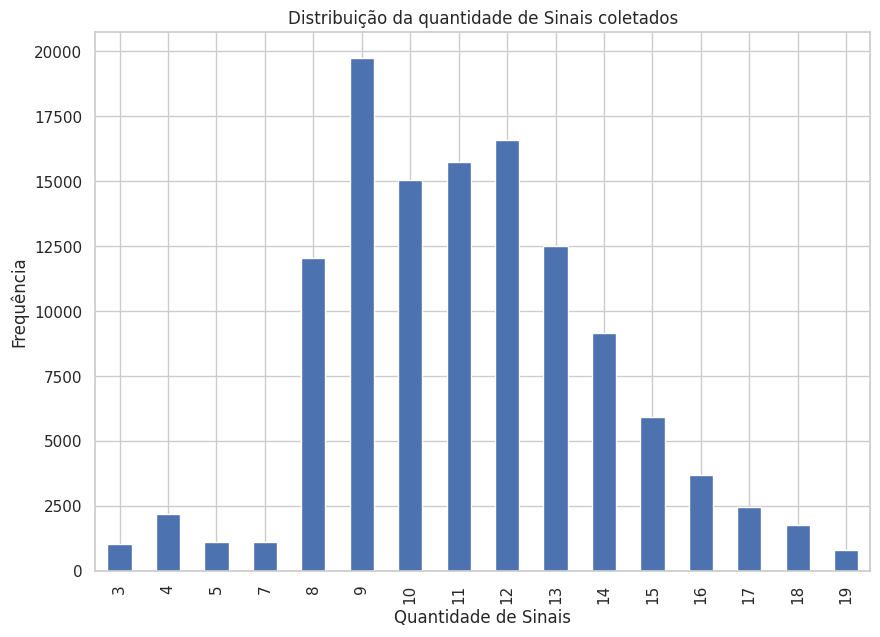

In [13]:
df['Sinais'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuição da quantidade de Sinais coletados')
plt.xlabel('Quantidade de Sinais')
plt.ylabel('Frequência')
plt.show()

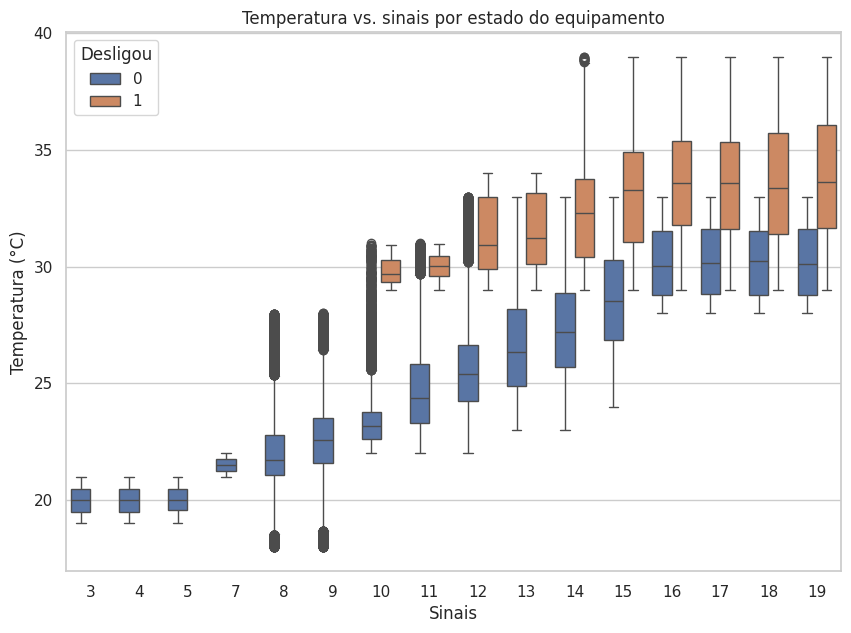

In [14]:
sns.boxplot(x='Sinais', y='Temperatura', hue='Desligou', data=df)
plt.title('Temperatura vs. sinais por estado do equipamento')
plt.xlabel('Sinais')
plt.ylabel('Temperatura (°C)')
plt.legend(title='Desligou')
plt.show()


# Classificação com Regressão Logística

In [15]:
X = df[colunas_numericas] # Features
y = df['Desligou'] # Target

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Tamanho do Treino: {X_train.shape}, Tamanho do Teste: {X_test.shape}")


Tamanho do Treino: (84672, 2), Tamanho do Teste: (36288, 2)


In [17]:
# Escalonamento (importante para muitos modelos)
scaler = StandardScaler() # Create an instance of StandardScaler

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
seed = 42
log_reg = LogisticRegression(random_state=seed)
log_reg.fit(X_train_scaled, y_train)
print("Modelo treinado!")

Modelo treinado!


In [19]:
print("\nRealizando previsões e avaliando o modelo...")
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled) # Probabilidades para a classe 1 (Desligou)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do Modelo: {accuracy:.4f}")


Realizando previsões e avaliando o modelo...

Acurácia do Modelo: 0.9391


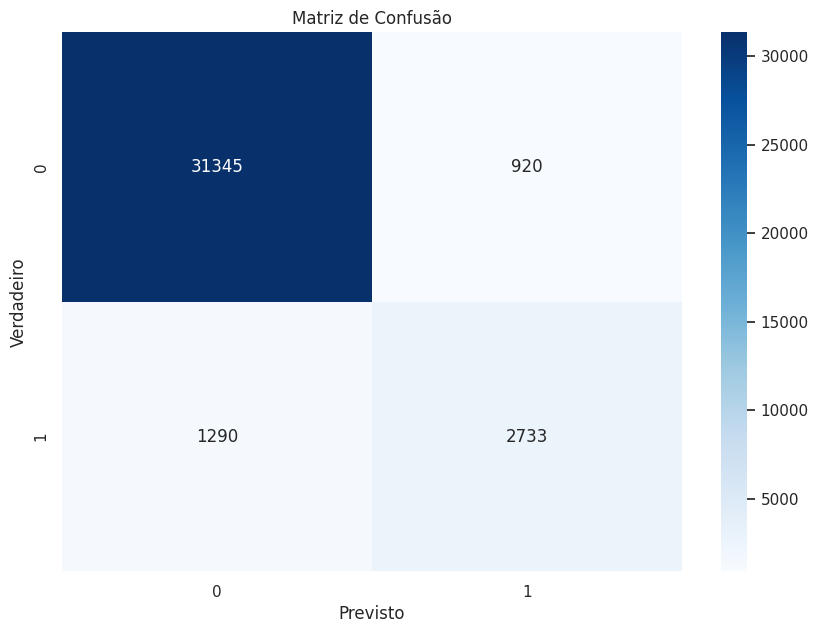

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     32265
           1       0.75      0.68      0.71      4023

    accuracy                           0.94     36288
   macro avg       0.85      0.83      0.84     36288
weighted avg       0.94      0.94      0.94     36288



In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(y_test, y_pred))

In [21]:
# Coeficientes
print(f"\nCoeficiente (Temperatura): {log_reg.coef_}")
print(f"Intercepto: {log_reg.intercept_}")



Coeficiente (Temperatura): [[3.56438401 0.06542545]]
Intercepto: [-5.40842796]


In [22]:
# Visualização da Curva Sigmoide (para uma feature)
X_test_sorted_indices = np.argsort(X_test['Temperatura'])
X_test_sorted = X_test['Temperatura'].iloc[X_test_sorted_indices]
y_proba_lr_sorted = y_proba[X_test_sorted_indices, 1]

y_test_sorted = y_test.iloc[X_test_sorted_indices]


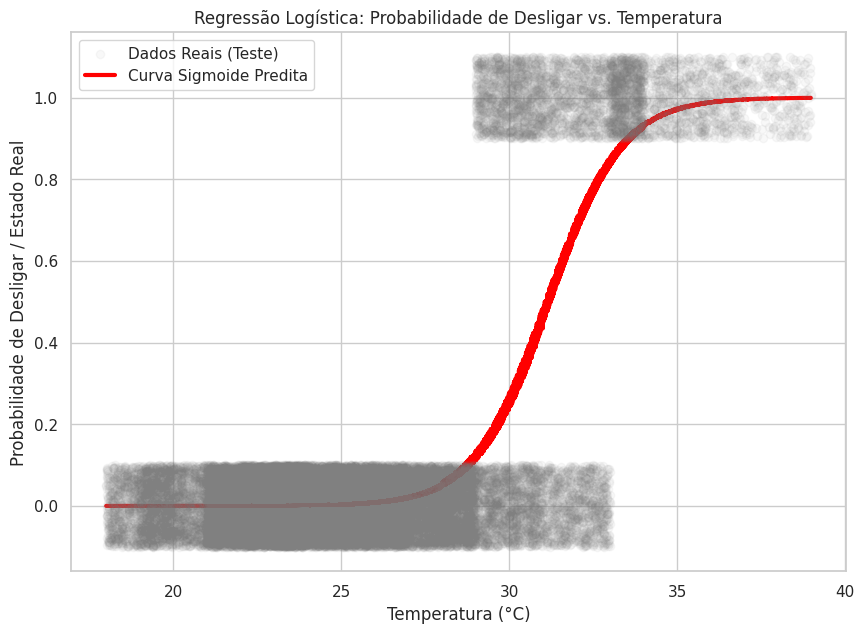

In [23]:
jitter = 0.1
y_jitter = y_test_sorted + np.random.uniform(-jitter, jitter, size=len(y_test_sorted))

plt.scatter(X_test_sorted, y_jitter, color='gray', zorder=20, alpha=0.05, label='Dados Reais (Teste)')

plt.plot(X_test_sorted, y_proba_lr_sorted, color='red', lw=3, label='Curva Sigmoide Predita')

plt.ylabel('Probabilidade de Desligar / Estado Real')
plt.xlabel('Temperatura (°C)')
plt.title('Regressão Logística: Probabilidade de Desligar vs. Temperatura')
plt.legend()
plt.show()

In [24]:
def predizerQuebra(Temperatura):
  input_scaled = scaler.transform(Temperatura)

  predicted_class = log_reg.predict(input_scaled)
  prediction_proba = log_reg.predict_proba(input_scaled)

  predicted_class = log_reg.predict(input_scaled)
  prediction_proba = log_reg.predict_proba(input_scaled)
  prob_desligou = prediction_proba[0][1]

  print(f"\nTemperatura informada: {Temperatura[0][0]}°C")
  print(f"Classe Predita: {'Desligou' if predicted_class == 1 else 'Não Desligou'}")
  print(f"Probabilidade de Desligar: {prob_desligou:.4f}")

  plotarPredicao(Temperatura[0][0], prob_desligou)

In [25]:
def plotarPredicao(Temperatura, prob_desligou):
  X_test_sorted_indices = np.argsort(X_test['Temperatura'])
  X_test_sorted = X_test['Temperatura'].iloc[X_test_sorted_indices]
  y_proba_lr_sorted = y_proba[X_test_sorted_indices, 1]

  y_test_sorted = y_test.iloc[X_test_sorted_indices]

  jitter = 0.1
  y_jitter = y_test_sorted + np.random.uniform(-jitter, jitter, size=len(y_test_sorted))
  plt.scatter(X_test_sorted, y_jitter, color='gray', zorder=20, alpha=0.05, label='Dados Reais (Teste)')
  plt.plot(X_test_sorted, y_proba_lr_sorted, color='red', lw=3, label='Curva Sigmoide Predita')

  # Plote o ponto da temperatura de input e sua probabilidade predita
  plt.scatter(Temperatura, prob_desligou, color='green', s=100, zorder=25, label=f'Input ({Temperatura}°C)')

  plt.ylabel('Probabilidade de Desligar / Estado Real')
  plt.xlabel('Temperatura (°C)')
  plt.title('Regressão Logística: Probabilidade de Desligar vs. Temperatura com Input')
  plt.legend()
  plt.grid(True)
  plt.show()

Por favor, digite a temperatura para previsão (ex: 25.5): 32

Temperatura informada: 32.0°C
Classe Predita: Desligou
Probabilidade de Desligar: 0.6570


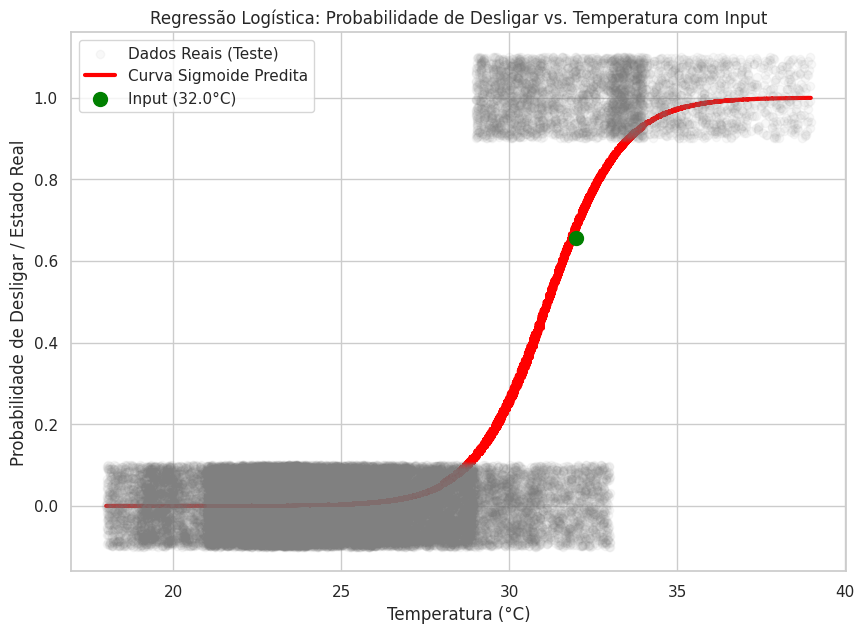

In [26]:
input_temperature = float(input("Por favor, digite a temperatura para previsão (ex: 25.5): "))
#input_temperature = float(25.0)
input_sinais = float(10)

novaTemperatura = np.array([[input_temperature, input_sinais]])

predizerQuebra(novaTemperatura)

# Detecção de Anomalias com Isolation Forest

In [34]:
df_anomalias_detection = df.copy()

In [35]:
# Função para gerar anomalias sintéticas (exemplo simples)
def gerar_anomalias_sinteticas(df_input, n_anomalias):
    col_temp = 'Temperatura'
    col_param = 'Sinais'
    fator_temp = 2
    val_param_anomalo=20

    df_mod = df_input.copy()
    indices_anomalias = np.random.choice(df_mod.index, n_anomalias, replace=False)

    # Criar uma coluna para marcar anomalias sintéticas (apenas para nossa verificação)
    df_mod['anomaliaGerada'] = 0

    for idx in indices_anomalias:
        df_mod.loc[idx, col_temp] = df_mod.loc[idx, col_temp] * fator_temp # Anomalia de temperatura alta
        if np.random.rand() > 0.5: # Aleatoriamente, também mudar o Sinal
             df_mod.loc[idx, col_param] = val_param_anomalo # Um valor claramente fora do comum
        #df_mod.loc = 1
        df_mod.loc[idx, 'anomaliaGerada'] = 1

    return df_mod

In [53]:
# Gerar algumas anomalias artificiais (~2% do df)
num_anomalias_artificiais = int(0.02 * len(df_anomalias_detection))
df_com_sinteticas = gerar_anomalias_sinteticas(df_anomalias_detection, num_anomalias_artificiais)

print(f"{num_anomalias_artificiais} anomalias artificiai geradas")
print(f"{len(df_com_sinteticas[df_com_sinteticas['anomaliaGerada'] == 1])} anomalias artificiais encontradas no dataset")
print("\nExemplo de anomalias artificiais:")
print(df_com_sinteticas[df_com_sinteticas['anomaliaGerada'] == 1].head())


2419 anomalias artificiai geradas
2419 anomalias artificiais encontradas no dataset

Exemplo de anomalias artificiais:
      ID           Timestamp  Temperatura  Sinais  Desligou  Dia DiaSemana  \
10    11 2018-04-30 02:36:50        39.30      20         0   30    Monday   
58    59 2018-04-30 02:40:50        39.12      20         0   30    Monday   
290  291 2018-04-30 03:00:10        40.76       4         0   30    Monday   
426  427 2018-04-30 03:11:30        40.10      20         0   30    Monday   
452  453 2018-04-30 03:13:40        38.86      20         0   30    Monday   

         Hora  anomaliaGerada  
10   02:36:50               1  
58   02:40:50               1  
290  03:00:10               1  
426  03:11:30               1  
452  03:13:40               1  


In [54]:
# Selecionar features para o Isolation Forest
features_if = ['Temperatura', 'Sinais']
X_if = df_com_sinteticas[features_if]

In [55]:
# 'auto' = o algoritmo estima o % de contaminação | pode-se definir um valor (0.05 para 5%)
model_if = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

df_com_sinteticas['anomaly_if_pred'] = model_if.fit_predict(X_if)
df_com_sinteticas['anomaly_score_if'] = model_if.decision_function(X_if)


In [62]:
# Análise dos Resultados
anomalias_detectadas = df_com_sinteticas[df_com_sinteticas['anomaly_if_pred'] == -1]
print(f"\nTotal de anomalias detectadas pelo Isolation Forest: {len(anomalias_detectadas)}")

# Verificar quantas das anomalias sintéticas foram detectadas
print(f"\nAnomalias sintéticas detectadas: {num_anomalias_artificiais} de {len(anomalias_detectadas)}")


print(f"\nExemplos de anomalias naturais detectadas ({len(anomalias_detectadas[anomalias_detectadas['anomaliaGerada'] == 0])}):")
print(anomalias_detectadas[anomalias_detectadas['anomaliaGerada'] == 0].head())

print(f"\nExemplos de anomalias artificiais detectadas ({len(anomalias_detectadas[anomalias_detectadas['anomaliaGerada'] == 1])}):")
print(anomalias_detectadas[anomalias_detectadas['anomaliaGerada'] == 1].head())





Total de anomalias detectadas pelo Isolation Forest: 24133

Anomalias sintéticas detectadas: 2419 de 24133

Exemplos de anomalias naturais detectadas (21714):
   ID           Timestamp  Temperatura  Sinais  Desligou  Dia DiaSemana  \
0   1 2018-04-30 02:36:00        19.59       5         0   30    Monday   
1   2 2018-04-30 02:36:05        19.18       4         0   30    Monday   
2   3 2018-04-30 02:36:10        19.38       3         0   30    Monday   
3   4 2018-04-30 02:36:15        19.26       4         0   30    Monday   
4   5 2018-04-30 02:36:20        19.52       5         0   30    Monday   

       Hora  anomaliaGerada  anomaly_if_pred  anomaly_score_if  
0  02:36:00               0               -1         -0.109261  
1  02:36:05               0               -1         -0.133323  
2  02:36:10               0               -1         -0.162211  
3  02:36:15               0               -1         -0.128444  
4  02:36:20               0               -1         -0.109261  

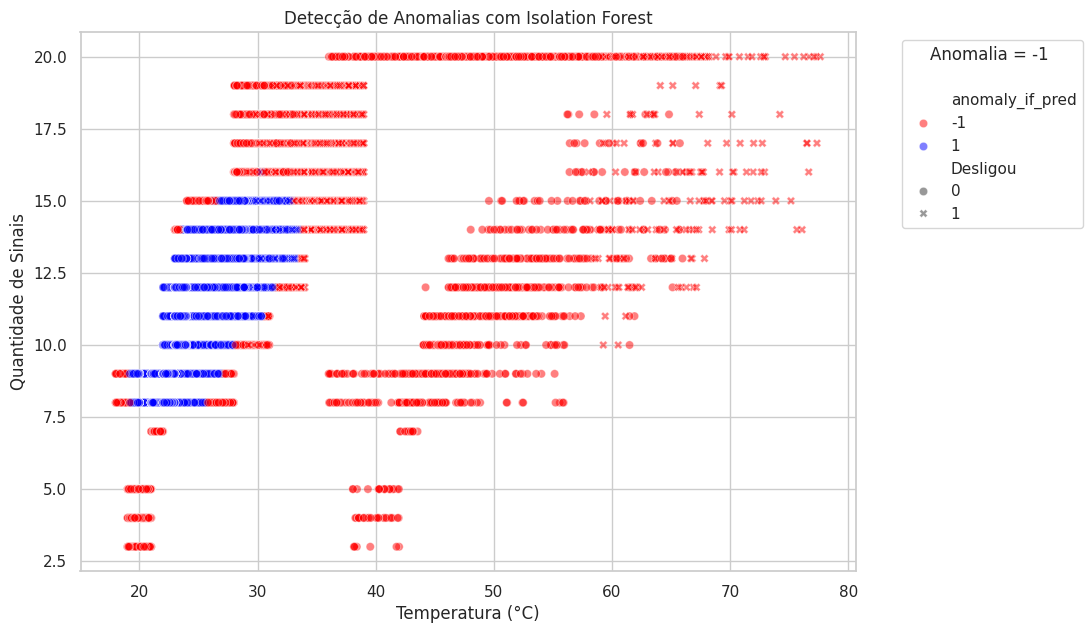

In [64]:
sns.scatterplot(x='Temperatura', y='Sinais', hue='anomaly_if_pred', data=df_com_sinteticas,
                palette={1: 'blue', -1: 'red'}, style='Desligou', sizes=(20, 200), alpha=0.5)
plt.title('Detecção de Anomalias com Isolation Forest')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Quantidade de Sinais')
plt.legend(title='Anomalia = -1 \n', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()